### Target：$f(x_1,x_2,x_3,x_4)={\rm exp}({\rm sin}(x_1^2+x_2^2)+{\rm sin}(x_3^2+x_4^2))$

# TaylorKAN

Epoch [500/5000], Loss: 0.1931
Epoch [1000/5000], Loss: 0.0283
Epoch [1500/5000], Loss: 0.0014
Epoch [2000/5000], Loss: 0.0006
Epoch [2500/5000], Loss: 0.0004
Epoch [3000/5000], Loss: 0.0004
Epoch [3500/5000], Loss: 0.0009
Epoch [4000/5000], Loss: 0.0008
Epoch [4500/5000], Loss: 0.0003
Epoch [5000/5000], Loss: 0.0004
Test Loss (MSE): 0.0008
Test Mean Absolute Error (MAE): 0.0261
Test R² Score: 0.9996


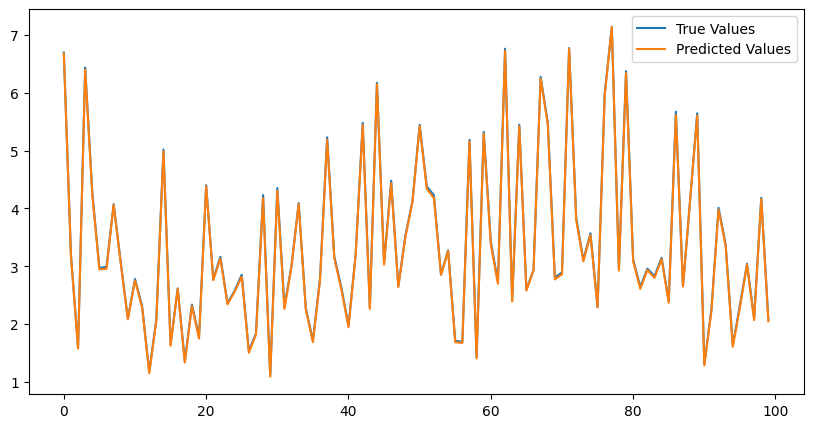

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)
        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorNN(nn.Module):
    def __init__(self):
        super(TaylorNN, self).__init__()
        self.taylor1 = TaylorLayer(4, 128, 3)
        self.taylor2 = TaylorLayer(128, 64, 3)
        self.taylor3 = TaylorLayer(64, 1, 3)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.selu(self.taylor1(x))
        x = F.selu(self.taylor2(x))
        x = self.taylor3(x)
        return x

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + np.sin(x3**2 + x4**2))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

model = TaylorNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# CNN

Epoch [500/5000], Loss: 0.1401
Epoch [1000/5000], Loss: 0.0513
Epoch [1500/5000], Loss: 0.0312
Epoch [2000/5000], Loss: 0.0254
Epoch [2500/5000], Loss: 0.0177
Epoch [3000/5000], Loss: 0.0121
Epoch [3500/5000], Loss: 0.0124
Epoch [4000/5000], Loss: 0.0083
Epoch [4500/5000], Loss: 0.0090
Epoch [5000/5000], Loss: 0.0040
Test Loss (MSE): 0.0053
Test Mean Absolute Error (MAE): 0.0601
Test R² Score: 0.9967


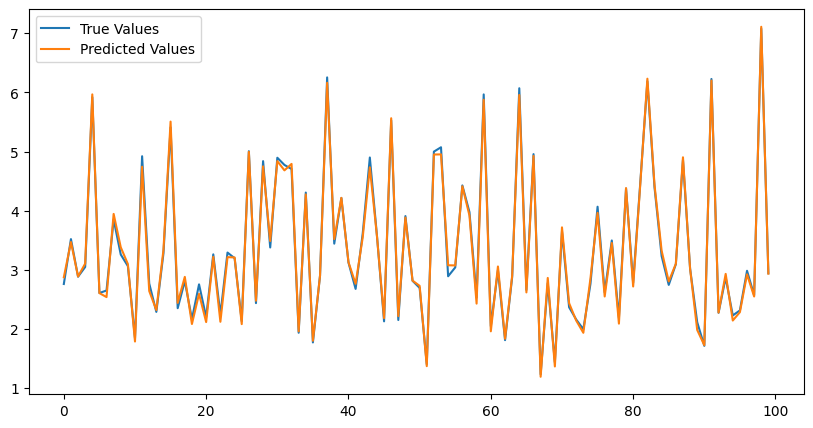

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + np.sin(x3**2 + x4**2))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(32 * 2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# MLP

Epoch [500/5000], Loss: 0.1088
Epoch [1000/5000], Loss: 0.0255
Epoch [1500/5000], Loss: 0.0610
Epoch [2000/5000], Loss: 0.0505
Epoch [2500/5000], Loss: 0.0481
Epoch [3000/5000], Loss: 0.0483
Epoch [3500/5000], Loss: 0.0153
Epoch [4000/5000], Loss: 0.0210
Epoch [4500/5000], Loss: 0.0284
Epoch [5000/5000], Loss: 0.0290
Test Loss (MSE): 0.0304
Test Mean Absolute Error (MAE): 0.1140
Test R² Score: 0.9854


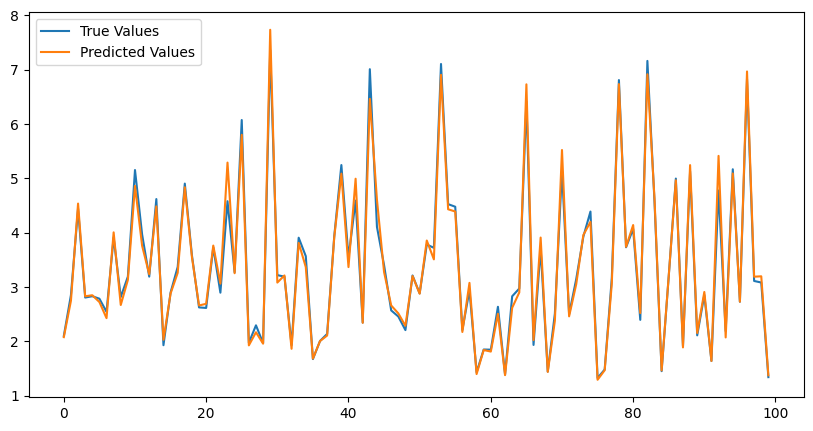

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + np.sin(x3**2 + x4**2))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# TaylorCNN

Epoch [500/5000], Loss: 0.107587
Epoch [1000/5000], Loss: 0.033993
Epoch [1500/5000], Loss: 0.056089
Epoch [2000/5000], Loss: 0.020142
Epoch [2500/5000], Loss: 0.020510
Epoch [3000/5000], Loss: 0.019178
Epoch [3500/5000], Loss: 0.009686
Epoch [4000/5000], Loss: 0.017103
Epoch [4500/5000], Loss: 0.004735
Epoch [5000/5000], Loss: 0.006494
Test Loss (MSE): 0.005464
Test Mean Absolute Error (MAE): 0.054616
Test R² Score: 0.997580


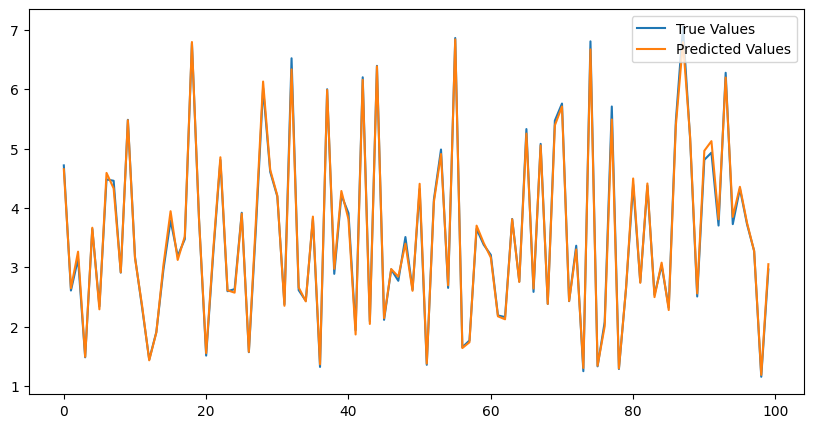

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + np.sin(x3**2 + x4**2))
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorMLP(nn.Module):
    def __init__(self):
        super(TaylorMLP, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.taylor = TaylorLayer(64, 1, order=5) 
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.taylor(x)
        return x

model = TaylorMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss:.6f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.6f}')
    print(f'Test R² Score: {r2_score:.6f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

### Target：$ f(x_1, x_2, x_3, x_4) = \exp(\sin(x_1^2 + x_2^2) + \sin(x_3^2 + x_4^2) + x_1^5 + x_2^4 \cdot x_3^3 + \log(1 + |x_4|)) $

# TaylorKAN

Epoch [500/5000], Loss: 2.2477
Epoch [1000/5000], Loss: 2.6983
Epoch [1500/5000], Loss: 1.2086
Epoch [2000/5000], Loss: 1.0012
Epoch [2500/5000], Loss: 1.0645
Epoch [3000/5000], Loss: 0.2864
Epoch [3500/5000], Loss: 0.1924
Epoch [4000/5000], Loss: 0.4117
Epoch [4500/5000], Loss: 1.0540
Epoch [5000/5000], Loss: 0.1745
Test Loss (MSE): 0.2075
Test Mean Absolute Error (MAE): 0.2927
Test R² Score: 0.9929


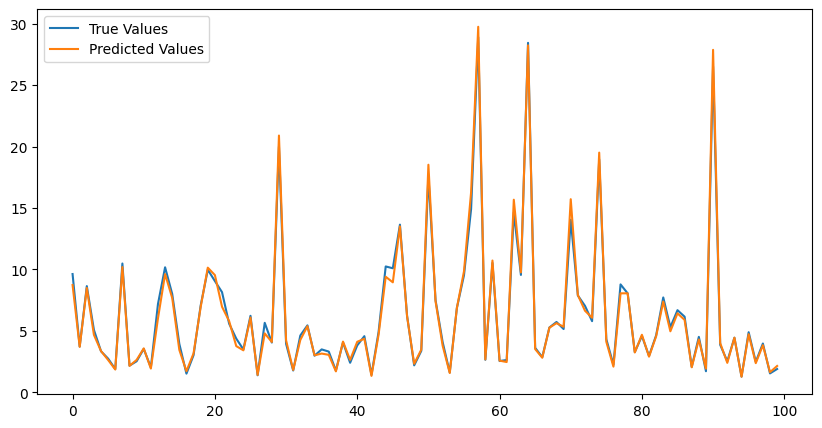

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)
        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorNN(nn.Module):
    def __init__(self):
        super(TaylorNN, self).__init__()
        self.taylor1 = TaylorLayer(4, 128, 3)
        self.taylor2 = TaylorLayer(128, 64, 3)
        self.taylor3 = TaylorLayer(64, 1, 3)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.selu(self.taylor1(x))
        x = F.selu(self.taylor2(x))
        x = self.taylor3(x)
        return x

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + 
               np.sin(x3**2 + x4**2) + 
               x1**5 + x2**4 * x3**3 + 
               np.log(1 + np.abs(x4)))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

model = TaylorNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# CNN

Epoch [500/5000], Loss: 4.4446
Epoch [1000/5000], Loss: 2.5597
Epoch [1500/5000], Loss: 1.1374
Epoch [2000/5000], Loss: 1.1631
Epoch [2500/5000], Loss: 0.6003
Epoch [3000/5000], Loss: 0.9615
Epoch [3500/5000], Loss: 0.5817
Epoch [4000/5000], Loss: 0.5540
Epoch [4500/5000], Loss: 0.3313
Epoch [5000/5000], Loss: 0.3289
Test Loss (MSE): 0.2068
Test Mean Absolute Error (MAE): 0.3332
Test R² Score: 0.9812


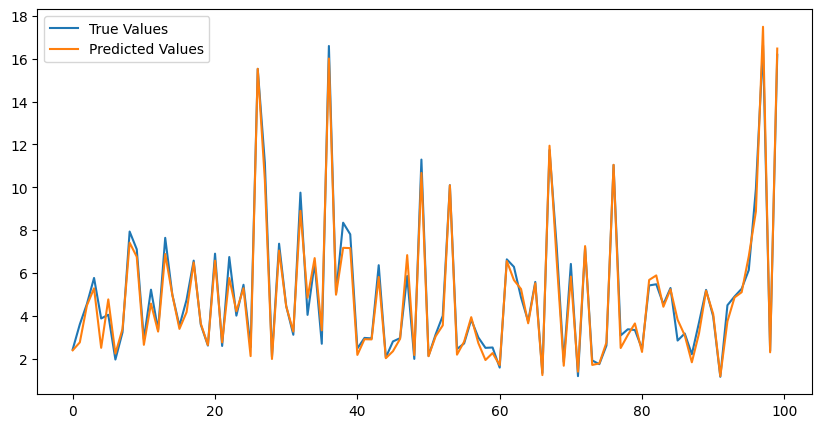

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + 
               np.sin(x3**2 + x4**2) + 
               x1**5 + x2**4 * x3**3 + 
               np.log(1 + np.abs(x4)))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(32 * 2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# MLP

Epoch [500/5000], Loss: 4.5524
Epoch [1000/5000], Loss: 1.5104
Epoch [1500/5000], Loss: 2.0987
Epoch [2000/5000], Loss: 0.6787
Epoch [2500/5000], Loss: 0.6383
Epoch [3000/5000], Loss: 0.7740
Epoch [3500/5000], Loss: 0.4706
Epoch [4000/5000], Loss: 0.5737
Epoch [4500/5000], Loss: 0.3860
Epoch [5000/5000], Loss: 0.3212
Test Loss (MSE): 0.4615
Test Mean Absolute Error (MAE): 0.4388
Test R² Score: 0.9682


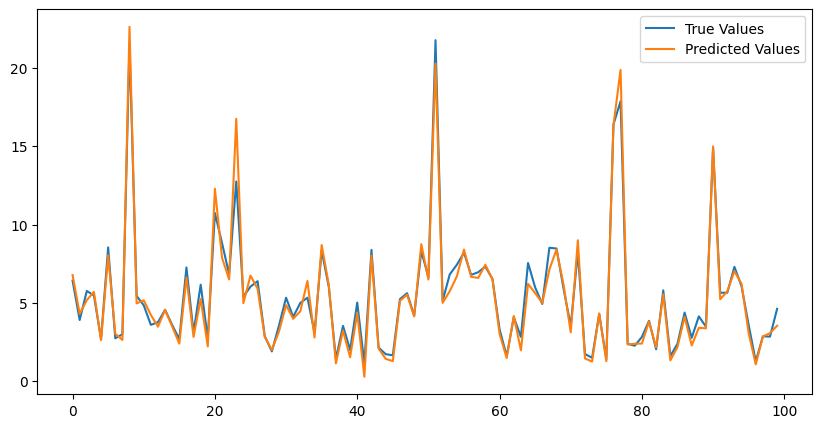

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + 
               np.sin(x3**2 + x4**2) + 
               x1**5 + x2**4 * x3**3 + 
               np.log(1 + np.abs(x4)))
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Test R² Score: {r2_score:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()

# TaylorCNN

Epoch [500/5000], Loss: 1.039461
Epoch [1000/5000], Loss: 0.711158
Epoch [1500/5000], Loss: 1.070198
Epoch [2000/5000], Loss: 0.428362
Epoch [2500/5000], Loss: 0.958893
Epoch [3000/5000], Loss: 0.391343
Epoch [3500/5000], Loss: 0.210088
Epoch [4000/5000], Loss: 0.076311
Epoch [4500/5000], Loss: 0.127334
Epoch [5000/5000], Loss: 0.145294
Test Loss (MSE): 0.239226
Test Mean Absolute Error (MAE): 0.286486
Test R² Score: 0.987939


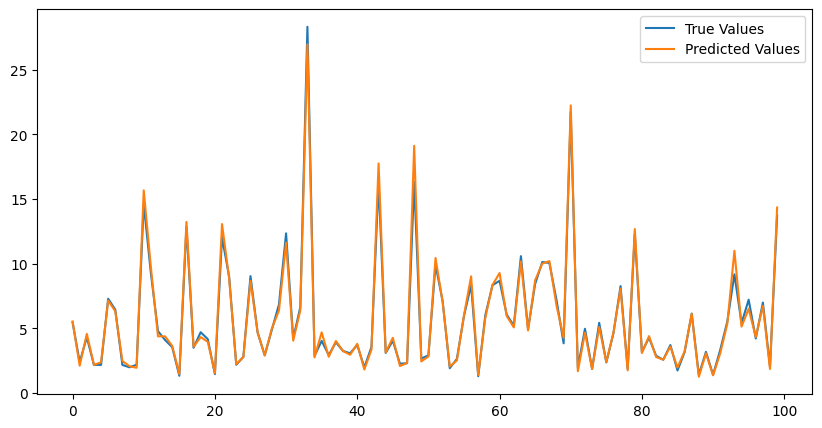

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples):
    x1 = np.random.uniform(-1, 1, num_samples)
    x2 = np.random.uniform(-1, 1, num_samples)
    x3 = np.random.uniform(-1, 1, num_samples)
    x4 = np.random.uniform(-1, 1, num_samples)
    x = np.stack([x1, x2, x3, x4], axis=1)
    y = np.exp(np.sin(x1**2 + x2**2) + 
               np.sin(x3**2 + x4**2) + 
               x1**5 + x2**4 * x3**3 + 
               np.log(1 + np.abs(x4)))
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorMLP(nn.Module):
    def __init__(self):
        super(TaylorMLP, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.taylor = TaylorLayer(64, 1, order=5)  
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.taylor(x)
        return x

model = TaylorMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    x_train, y_train = generate_data(batch_size)
    
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

model.eval()
with torch.no_grad():
    x_test, y_test = generate_data(100)
    predictions = model(x_test)
    test_loss = criterion(predictions, y_test)

    # Calculate MAE and R² score
    mae = torch.mean(torch.abs(predictions - y_test)).item()
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - predictions) ** 2)
    r2_score = 1 - ss_residual / ss_total

    print(f'Test Loss (MSE): {test_loss:.6f}')
    print(f'Test Mean Absolute Error (MAE): {mae:.6f}')
    print(f'Test R² Score: {r2_score:.6f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.cpu().numpy(), label='True Values')
    plt.plot(predictions.cpu().numpy(), label='Predicted Values')
    plt.legend(loc='best')
    plt.show()